In [1]:
%matplotlib inline

## Mass spectrometry and itcsimlib

In addition to ITC data, itcsimlib can also simulate mass spectrometry (MS) data, by virtue of it's tracking of macromolecule + ligand configurations. In fact, some of itcsimlib's MS methods (such as population graphs) may likely prove useful to the researcher even for systems that are probed experimentally by ITC.

The key difference between fitting/simulating ITC data and MS data is the use of MSExperiments instead of ITCExperiments, and MSModels instead of ITC models.

### MS Experiments
Mass spec experiments, like ITC experiments, can come in two flavors: regular experiments for fitting empirical data, and "synthetic" experiments for simulating theoretical conditions (which are empty until data is generated for them).

In [2]:
from numpy import linspace
from itcsimlib.mass_spec import MSExperimentSynthetic

synthetic_exp = MSExperimentSynthetic(
    title="Simulated MS Experiment",
    lattice_name="TRAP11",
    lattice_concs=[1E-6]*20,
    ligand_name="Trp",
    ligand_concs=linspace(0,2E-5,20),
    noise=0.02)
print synthetic_exp

Synthetic experiment has not yet been generated - attach to a simulator and run to populate


### MS Models

Conveniently, nearly any Ising-based model can be automatically converted to a MS model, as shown.

In [3]:
from itcsimlib.model_ising import NonAdditive
from itcsimlib.mass_spec import MSModel

itc_model = NonAdditive(
    nsites=11, circular=1, units="J",
    lattice_name="TRAP11", ligand_name="Trp",
)
itc_model.set_params(dGX=-27000, dGY=-27000, dGZ=-30000)

ms_model = MSModel(itc_model)
print ms_model


Model: itcsimlib.mass_spec.MSModel

Description:
A model adapted from base type "itcsimlib.model_ising.NonAdditive" for fitting mass spectrometric population data.

Original docstring:
An Ising-type model, in which ligands bind to either a linear or circular lattice. Binding energy depends upon whether zero, one, or both neighboring sites are occupied.

Components:
Index	Name	Description
1)	TRAP11	A circular lattice with 11 binding sites
2)	Trp	A lattice-binding ligand

Parameters:
Index	Param     Type                Value               Description
1)	dGX       Free energy         -27000.000 J/mol    Free energy change upon binding to a site flanked by two unoccupied
2)	dGY       Free energy         -27000.000 J/mol    Free energy change upon binding to a site flanked by one occupied
3)	dGZ       Free energy         -30000.000 J/mol    Free energy change upon binding to a site flanked by two occupied
4)	dHX       Enthalpy            0.000 J/mol         Enthalpy change upon binding to 

Itcsimlib utilizes mass spectrometry data as the relative abundance of different lattice+ligand stoichiometries at different concentrations of the two components. With no ligand present, only lattices with no bound ligands will exist. As the ligand concentration increases, increasingly saturated lattices will become more prevalent.

Here we can see that our predicted model parameters result in a relatively poor fit to the available empirical data.

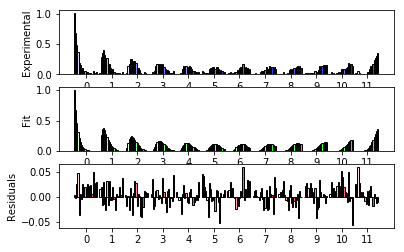

In [4]:
from itcsimlib import ITCSim

sim = ITCSim(verbose=True, threads=1, units="J")

sim.add_experiment( synthetic_exp )
sim.set_model( ms_model )
sim.run()
synthetic_exp.export_to_file("/Users/elihuihms/Desktop/sim_ms_data.txt")
sim.experiments[0].make_plot()

We can also generate these individual population plots in an attractive 3D format:

<Figure size 432x288 with 0 Axes>

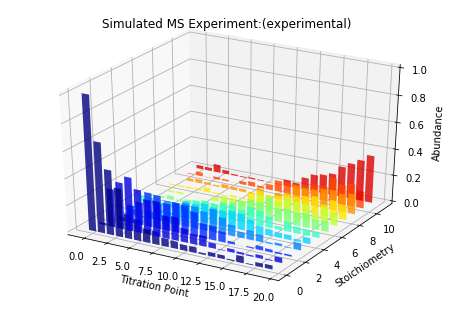

<Figure size 432x288 with 0 Axes>

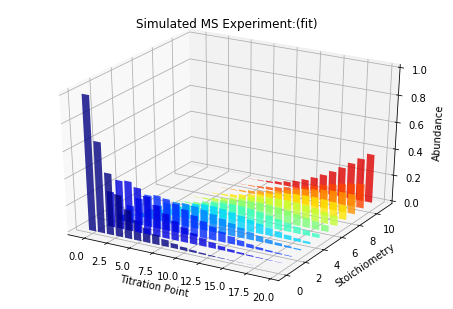

<Figure size 432x288 with 0 Axes>

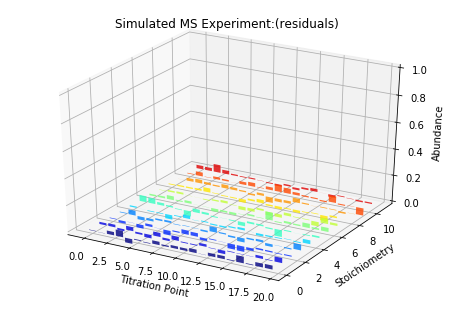

In [5]:
sim.experiments[0].make_population_plot(dataset="experimental")
sim.experiments[0].make_population_plot(dataset="fit")
sim.experiments[0].make_population_plot(dataset="residuals")

### Fitting MS data

Fitting MS data works just like fitting ITC data, in that it utilizes the existing ITCFit class:

Title: Cooperative binding of Trp to TRAP11
Temperature: 298.15 K
Titration points: 12
Stoichiometries: 12
Components:
	Lattice: "TRAP11"
	Ligand: "Trp"



<Figure size 432x288 with 0 Axes>

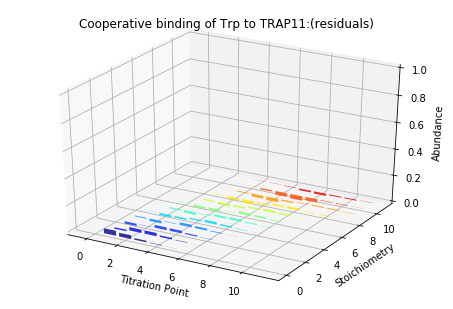

(OrderedDict([('dGX', -28014.378315550333), ('dGY', -28778.766286569928)]), 0.048887454174136057)


In [7]:
from itcsimlib import ITCFit
from itcsimlib.mass_spec import MSExperiment

empirical_exp = MSExperiment("data/TRAP_populations_EDDA.txt")
print empirical_exp

sim.remove_all_experiments()
sim.add_experiment( empirical_exp )

opt = ITCFit(sim).optimize(params=('dGX','dGY'), update_fits=True)

sim.experiments[0].make_population_plot(dataset="residuals")
print opt